/tmp/ipykernel_75013/3099596354.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)


Paso 1 completado: Preprocesamiento y análisis de variables
Scores calculados para status
Scores calculados para credit_history
Scores calculados para purpose
Scores calculados para savings
Scores calculados para employment
Scores calculados para personal_status
Scores calculados para other_debtors
Scores calculados para property
Scores calculados para other_installment_plans
Scores calculados para housing
Scores calculados para job
Scores calculados para telephone
Scores calculados para foreign_worker
Parámetros de score calculados para duration
Parámetros de score calculados para amount
Parámetros de score calculados para installment_rate
Parámetros de score calculados para residence_since
Parámetros de score calculados para age
Parámetros de score calculados para existing_credits
Parámetros de score calculados para num_dependents
Paso 2 completado: Sistema de scoring para todas las variables
Paso 3 completado: Mapeo a las 5 C's y sistema de scoring completo
Paso 4 completado: Sistem

/tmp/ipykernel_75013/3099596354.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
/tmp/ipykernel_75013/3099596354.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
/tmp/ipykernel_75013/3099596354.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  an

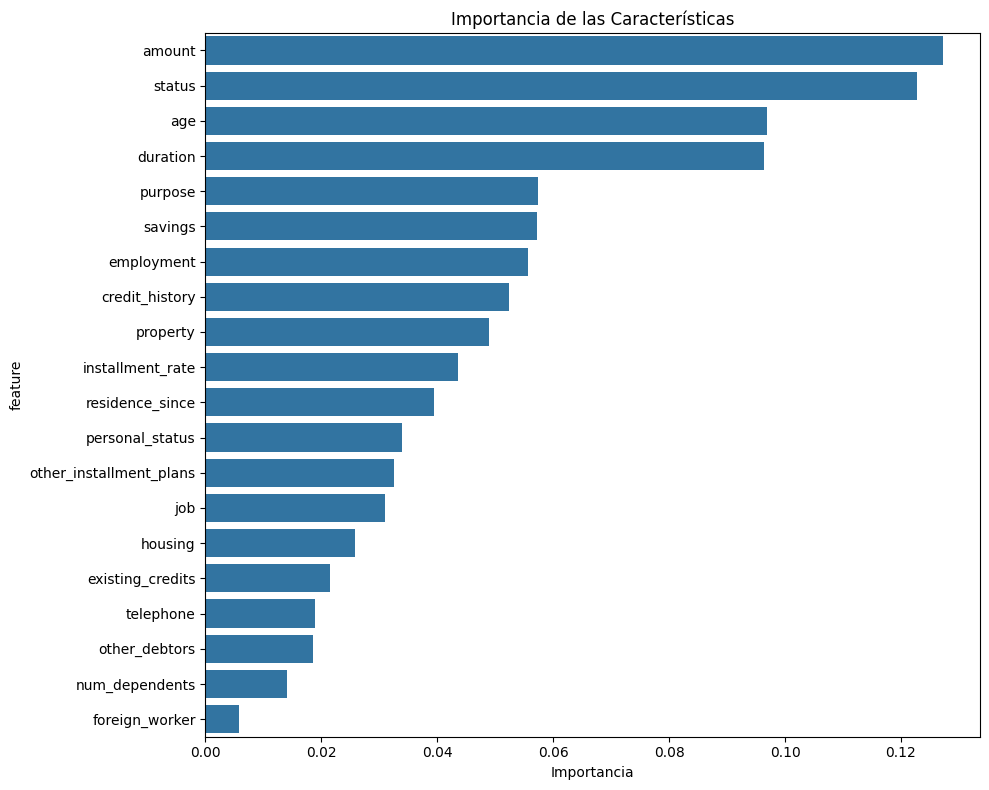

Paso 5 completado: Visualización de resultados

Resultado para nueva instancia:
Probabilidad de default: 0.610
Categoría de riesgo: Alto
Scores por categoría:
  Carácter: 3.38
  Capacidad: 4.14
  Capital: 5.00
  Colateral: 5.00
  Condiciones: 1.00
Score total: 3.70


/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/sklearn/utils/valida

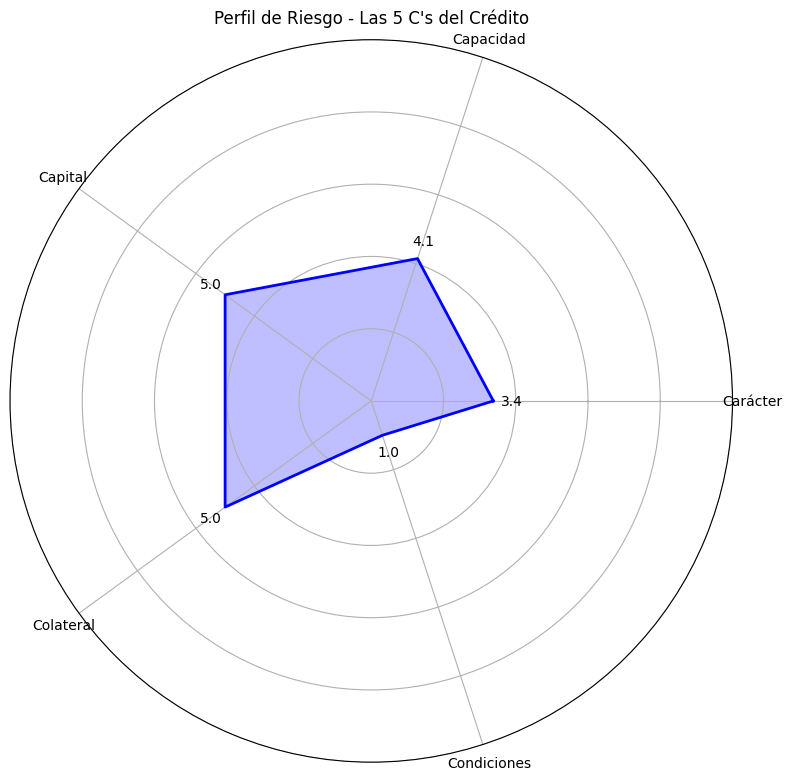

¡Sistema completo ejecutado exitosamente!


In [ ]:
# =============================================================================
# PASO 1: Preprocesamiento y Análisis de Todas las Variables
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Cargar datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = ['status', 'duration', 'credit_history', 'purpose', 'amount',
                'savings', 'employment', 'installment_rate', 'personal_status',
                'other_debtors', 'residence_since', 'property', 'age',
                'other_installment_plans', 'housing', 'existing_credits',
                'job', 'num_dependents', 'telephone', 'foreign_worker', 'target']

df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)
df['target'] = df['target'].replace({1: 0, 2: 1})  # 0 = Buen crédito, 1 = Default

# Codificar variables categóricas
label_encoders = {}
X_encoded = df.drop('target', axis=1).copy()

for column in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X_encoded[column])
    label_encoders[column] = le
    joblib.dump(le, f'label_encoder_{column}.pkl')

y = df['target']

# Escalar características numéricas
numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                    'age', 'existing_credits', 'num_dependents']
scaler = StandardScaler()
X_encoded[numeric_columns] = scaler.fit_transform(X_encoded[numeric_columns])
joblib.dump(scaler, 'scaler.pkl')

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42, 
                                class_weight='balanced')
model.fit(X_train, y_train)
joblib.dump(model, 'credit_scoring_model.pkl')

# Obtener importancia de características
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Paso 1 completado: Preprocesamiento y análisis de variables")

# =============================================================================
# PASO 2: Crear Sistema de Scoring para Todas las Variables
# =============================================================================

# Función para calcular scores para variables categóricas
def calculate_categorical_scores(df, column_name, target_name='target'):
    """
    Calcula scores para una variable categórica basado en la tasa de default
    """
    # Calcular tasa de default por categoría
    analysis = df.groupby(column_name)[target_name].agg(['count', 'mean']).reset_index()
    analysis.columns = [column_name, 'count', 'default_rate']
    analysis = analysis.sort_values('default_rate')
    
    # Asignar score (invertido: mayor tasa de default = menor score)
    max_rate = analysis['default_rate'].max()
    min_rate = analysis['default_rate'].min()
    
    if max_rate == min_rate:  # Evitar división por cero
        analysis['score'] = 5  # Valor neutral
    else:
        analysis['score'] = 10 - ((analysis['default_rate'] - min_rate) / 
                                 (max_rate - min_rate) * 9)  # Escala 1-10
    
    # Crear diccionario de mapeo
    score_map = dict(zip(analysis[column_name], analysis['score']))
    
    return score_map

# Función para calcular scores para variables numéricas
def calculate_numeric_scores(df, column_name, target_name='target', bins=5):
    """
    Calcula scores para una variable numérica mediante discretización
    Devuelve los límites de los bins y sus scores asociados
    """
    # Discretizar la variable numérica
    df['binned'] = pd.qcut(df[column_name], bins, duplicates='drop')
    
    # Calcular tasa de default por bin
    analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
    analysis.columns = ['binned', 'count', 'default_rate']
    analysis = analysis.sort_values('default_rate')
    
    # Asignar score
    max_rate = analysis['default_rate'].max()
    min_rate = analysis['default_rate'].min()
    
    if max_rate == min_rate:
        analysis['score'] = 5
    else:
        analysis['score'] = 10 - ((analysis['default_rate'] - min_rate) / 
                                 (max_rate - min_rate) * 9)
    
    # Extraer los intervalos y scores
    intervals = []
    scores = []
    for _, row in analysis.iterrows():
        intervals.append(row['binned'])
        scores.append(row['score'])
    
    return intervals, scores

# Calcular scores para todas las variables categóricas
categorical_columns = ['status', 'credit_history', 'purpose', 'savings', 
                        'employment', 'personal_status', 'other_debtors', 
                        'property', 'other_installment_plans', 'housing', 
                        'job', 'telephone', 'foreign_worker']

score_mappings = {}
for col in categorical_columns:
    score_mappings[col] = calculate_categorical_scores(df, col)
    print(f"Scores calculados para {col}")

# Calcular scores para todas las variables numéricas
numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                    'age', 'existing_credits', 'num_dependents']

numeric_score_params = {}
for col in numeric_columns:
    intervals, scores = calculate_numeric_scores(df, col)
    numeric_score_params[col] = {
        'intervals': intervals,
        'scores': scores
    }
    print(f"Parámetros de score calculados para {col}")

# Guardar los mapeos de scores
joblib.dump(score_mappings, 'categorical_score_mappings.pkl')
joblib.dump(numeric_score_params, 'numeric_score_params.pkl')

print("Paso 2 completado: Sistema de scoring para todas las variables")

# =============================================================================
# PASO 3: Mapeo a las 5 C's y Sistema de Scoring Completo
# =============================================================================

# Mapeo de variables a las 5 C's
c5_mapping = {
    'Carácter': ['status', 'credit_history', 'duration', 'purpose', 
                'personal_status', 'residence_since', 'foreign_worker'],
    'Capacidad': ['employment', 'installment_rate', 'age', 'existing_credits', 
                'job', 'num_dependents'],
    'Capital': ['savings', 'property'],
    'Colateral': ['other_debtors', 'housing', 'property'],
    'Condiciones': ['amount', 'other_installment_plans', 'telephone']
}

# Función para mapear valores numéricos a scores
def map_numeric_value_to_score(value, intervals, scores):
    """
    Mapea un valor numérico a un score basado en los intervalos
    """
    for i, interval in enumerate(intervals):
        if value in interval:
            return scores[i]
    return 5  # Valor por defecto si no está en ningún intervalo

# Función para calcular el score de una instancia
def calculate_instance_score(instance, score_mappings, numeric_score_params, c5_mapping):
    """
    Calcula el score para una instancia específica
    """
    scores = {category: [] for category in c5_mapping.keys()}
    
    # Procesar variables categóricas
    for col, mapping in score_mappings.items():
        value = instance[col]
        if value in mapping:
            score = mapping[value]
            # Asignar a la categoría correspondiente
            for category, features in c5_mapping.items():
                if col in features:
                    scores[category].append(score)
                    break
    
    # Procesar variables numéricas
    for col, params in numeric_score_params.items():
        if col in instance:
            value = instance[col]
            score = map_numeric_value_to_score(value, params['intervals'], params['scores'])
            # Asignar a la categoría correspondiente
            for category, features in c5_mapping.items():
                if col in features:
                    scores[category].append(score)
                    break
    
    # Calcular promedio por categoría
    final_scores = {}
    for category, values in scores.items():
        if values:
            final_scores[category] = sum(values) / len(values)
        else:
            final_scores[category] = 5  # Valor neutral si no hay datos
    
    # Calcular score total (promedio ponderado opcional)
    total_score = sum(final_scores.values()) / len(final_scores)
    
    return final_scores, total_score

print("Paso 3 completado: Mapeo a las 5 C's y sistema de scoring completo")

# =============================================================================
# PASO 4: Sistema para Nuevas Instancias
# =============================================================================

def predict_new_instance(new_data, model_path='credit_scoring_model.pkl', 
                        scaler_path='scaler.pkl', 
                        categorical_mappings_path='categorical_score_mappings.pkl',
                        numeric_params_path='numeric_score_params.pkl',
                        encoder_folder='.'):
    """
    Predice el score y riesgo para una nueva instancia
    """
    # Cargar modelo y transformadores
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    categorical_mappings = joblib.load(categorical_mappings_path)
    numeric_params = joblib.load(numeric_params_path)
    
    # Preprocesar la nueva instancia
    processed_data = new_data.copy()
    
    # Codificar variables categóricas
    for col in categorical_mappings.keys():
        if col in processed_data:
            try:
                le = joblib.load(f'{encoder_folder}/label_encoder_{col}.pkl')
                processed_data[col] = le.transform([processed_data[col]])[0]
            except (FileNotFoundError, ValueError):
                # Valor no visto durante el entrenamiento o encoder no encontrado
                processed_data[col] = -1  # Valor especial para desconocido
    
    # Escalar variables numéricas
    numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                        'age', 'existing_credits', 'num_dependents']
    for col in numeric_columns:
        if col in processed_data:
            try:
                processed_data[col] = scaler.transform([[processed_data[col]]])[0][0]
            except:
                # Si hay error en el escalado, mantener el valor original
                pass
    
    # Predecir probabilidad de default
    features = [processed_data[col] for col in model.feature_names_in_]
    default_probability = model.predict_proba([features])[0][1]
    
    # Calcular scores para las 5 C's
    c_scores, total_score = calculate_instance_score(processed_data, 
                                                    categorical_mappings, 
                                                    numeric_params, 
                                                    c5_mapping)
    
    return {
        'default_probability': default_probability,
        '5c_scores': c_scores,
        'total_score': total_score,
        'risk_category': 'Alto' if default_probability > 0.5 else 'Bajo'
    }

print("Paso 4 completado: Sistema para nuevas instancias")

# =============================================================================
# PASO 5: Visualización de Resultados
# =============================================================================

def plot_5c_scores(scores):
    """
    Visualiza los scores de las 5 C's en un gráfico radar
    """
    categories = list(scores.keys())
    values = list(scores.values())
    
    # Cerrar el círculo
    categories += categories[:1]
    values += values[:1]
    
    # Ángulos para cada categoría
    angles = [n / float(len(categories)-1) * 2 * np.pi for n in range(len(categories))]
    
    # Crear gráfico radar
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories[:-1])
    ax.set_ylim(0, 10)
    
    # Añadir valores
    for angle, value, category in zip(angles[:-1], values[:-1], categories[:-1]):
        ax.text(angle, value+0.5, f'{value:.1f}', ha='center', va='center')
    
    plt.title('Perfil de Riesgo - Las 5 C\'s del Crédito')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances):
    """
    Visualiza la importancia de las características
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances['importance'], y=importances['feature'])
    plt.title('Importancia de las Características')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()

# Visualizar importancia de características
plot_feature_importance(feature_importances)

print("Paso 5 completado: Visualización de resultados")

# =============================================================================
# EJEMPLO DE USO CON UNA NUEVA INSTANCIA
# =============================================================================

# Definir nueva instancia
new_instance = {
    'status': 'A11',
    'duration': 24,
    'credit_history': 'A32',
    'purpose': 'A43',
    'amount': 5000,
    'savings': 'A61',
    'employment': 'A73',
    'installment_rate': 4,
    'personal_status': 'A93',
    'other_debtors': 'A101',
    'residence_since': 2,
    'property': 'A121',
    'age': 35,
    'other_installment_plans': 'A143',
    'housing': 'A152',
    'existing_credits': 1,
    'job': 'A173',
    'num_dependents': 1,
    'telephone': 'A192',
    'foreign_worker': 'A201'
}

# Predecir
result = predict_new_instance(new_instance)

print("\nResultado para nueva instancia:")
print(f"Probabilidad de default: {result['default_probability']:.3f}")
print(f"Categoría de riesgo: {result['risk_category']}")
print("Scores por categoría:")
for category, score in result['5c_scores'].items():
    print(f"  {category}: {score:.2f}")
print(f"Score total: {result['total_score']:.2f}")

# Visualizar scores de las 5 C's
plot_5c_scores(result['5c_scores'])

print("¡Sistema completo ejecutado exitosamente!")